# fastbook 04_mnist_basics
> done

- toc:true
- branch: master
- badges: false
- comments: false 
- author: 최서연
- categories: [MNIST]

ref: https://github.com/fastai/fastbook

In [38]:
!pip install -Uqq fastbook

In [39]:
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

## Introduction

- We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically.
- We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches.
- We'll also describe the math that a basic neural network is actually doing.
- Finally, we'll put all these pieces together.

## End sidebar

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [5]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

Let's take a look in one of these folders (using sorted to ensure we all get the same order of file

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [7]:
im3_path=threes[1]
im3=Image.open(im3_path)
im3

Here we are using the *Image* class from the *Python Imaging Library (PIL)*, which is the most widely used Python package for opening, manipulating, and viewing images.

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image.

Here's the same thing as a PyTorch tensor:

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
im3_t=tensor(im3)
df=pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


- You can see that the background **white pixels are stored as the number 0**, **black is the number 255**, and **shades of gray are between the two**. 
-  The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels.

## Pixel Similarity

In [11]:
array(im3)[4:10,4:10]/255

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.11372549],
       [0.        , 0.        , 0.        , 0.18823529, 0.65098039,
        0.87843137],
       [0.        , 0.36470588, 0.95686275, 0.97647059, 0.99215686,
        0.73333333],
       [0.        , 0.41960784, 0.99215686, 0.99215686, 0.90196078,
        0.18823529],
       [0.        , 0.01176471, 0.07843137, 0.07843137, 0.05882353,
        0.        ]])

In [12]:
three_tensors=[tensor(Image.open(i)) for i in threes]
seven_tensors=[tensor(Image.open(i)) for i in sevens]

In [13]:
len(three_tensors),len(seven_tensors)

(6131, 6265)

Since we now *have tensors* (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it:`

<AxesSubplot:>

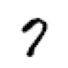

In [14]:
show_image(seven_tensors[3])

- For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 
    - 모든 픽셀 위치에서 해당 픽셀 강도의 모든 이미지에 대한 평균을 계산하기 위해서 
- To do this we first combine all the images in this list into a single three-dimensional tensor. 
    - 우선 이 리스트의 모든 이미지를 단일 3차원 텐서로 결합한다.
- The most common way to describe such a tensor is to call it a rank-3 tensor. 
- We often need to stack up individual tensors in a collection into a single tensor. 

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [15]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

In [16]:
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width

In [17]:
len(stacked_sevens.shape)

3

> important: rank is the number of axes or dimensions in a tensor; shape is the size of each axis of a tensor.

We can also get a tensor's rank directly with ndim:

In [18]:
stacked_sevens.ndim

3

for every pixel position, this will compute the average of that pixel over all images. 

The result will be one value for every pixel position, or a single image. Here it is:

<AxesSubplot:>

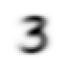

In [19]:
mean3=stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

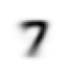

In [20]:
mean7=stacked_sevens.mean(0)
show_image(mean7)

<AxesSubplot:>

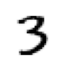

In [21]:
a_3 = stacked_threes[1]
show_image(a_3)

<AxesSubplot:>

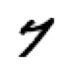

In [22]:
a_7 = stacked_sevens[1]
show_image(a_7)

<AxesSubplot:>

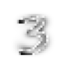

In [23]:
show_image(abs(a_3-mean3))

- We can't just add up the differences between the pixels of this image and the ideal digit. 
- Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal.
- That would be misleading!

1. Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or L1 norm
2. Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the root mean *squared error (RMSE)* or L2 norm.

In [24]:
dist_3_abs=(a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [25]:
dist_7_abs=(a_7 - mean7).abs().mean()
dist_7_sqr = ((a_7-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1304), tensor(0.2585))

- In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. 
- So our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [26]:
F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()

(tensor(0.1114), tensor(0.2021))

In [27]:
F.l1_loss(a_7.float(),mean7), F.mse_loss(a_7,mean7).sqrt()

(tensor(0.1304), tensor(0.2585))

Here mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value (in math it's called the L1 norm).

## Computing Metrics Using Broadcasting

In [28]:
valid_3_tens = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()]).float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [29]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [30]:
mnist_distance(a_3,mean3)

tensor(0.1114)

This is the same value we previously calculated for the distance between these two images, the ideal 3 mean3 and the arbitrary sample 3 a_3, which are both single-image tensors with a shape of [28,28].

In [31]:
valid_3_dist=mnist_distance(valid_3_tens,mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1421, 0.1246, 0.1330,  ..., 0.1656, 0.1222, 0.1477]),
 torch.Size([1010]))

PyTorch treats mean3, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set.

In [32]:
valid_3_tens.shape, mean3.shape, (valid_3_tens-mean3).shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]), torch.Size([1010, 28, 28]))

- PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

our function calls *mean((-1,-2))*. The tuple (-1,-2) represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was (1010). In other words, for every image, we averaged the intensity of all the pixels in that image.

We can use mnist_distance to figure out whether an image is a 3 or not by using the following logic: **if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3**. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [33]:
def is_3(x): return mnist_distance(x,mean3)<mnist_distance(x,mean7)

In [34]:
is_3(a_3),is_3(a_3).float()

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, **we get 1.0 for True and 0.0 for False**.

In [35]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [36]:
accuracy_3s=is_3(valid_3_tens).float().mean()
accuracy_7s = (1-is_3(valid_7_tens).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. 
- We want to find the specific values for the vector w that causes the result of our function to be high for those images that are actually 8s

Here are the steps that we are going to require, to turn this function into a machine learning classifier:
1. Initialize the weights. 
    - 가중치를 초기화한다.
        - We initialize the parameters to random values. 
2. For each image, use these weights to predict whether it appears to be a 3 or a 7.
    - 각 이미지에 대해 3이나 7로 나타나는지 예측하기 위해 가중치를 사용한다.
3. Based on these predictions, calculate how good the model is (its loss).
    - 이 예측을 바탕으로 모델이 얼마나 좋은지 즉, 손실을 계산한다.
        - We need some function that will return a number that is small if the performance of the model is good.
        - the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention.
4. Calculate the gradient, which measures for each weight, how changing that weight would change the loss
    - 각 가중치를 측정하는 기울기를 계산하고, 가중치가 변경되면 손실은 어떻게 변화하는지 계산한다.
5. Step (that is, change) all the weights based on that calculation.
    - 계산에 따라 모든 가중치를 단계, 즉 변경한다.
6. Go back to the step 2, and repeat the process.
    - 2단계로 돌아가서 과정을 반복한다.
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).
    - 학습 과정을 중단하기로 결정할떄까지 반복한다.(모델이 충분히 좋거나 더이상 기다리기 싫을때)
        - Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision.

- These seven steps, illustrated in <>, are the key to the training of all deep learning models.
- That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive.

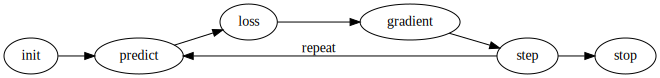

In [40]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

let's pretend that this is our loss function, and x is a weight parameter of the function:

In [41]:
def f(x): return x**2

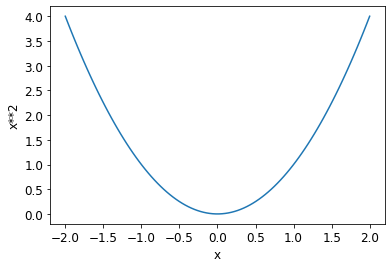

In [46]:
plot_function(f,'x','x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

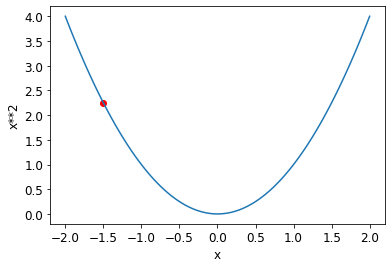

In [47]:
plot_function(f,'x','x**2')
plt.scatter(-1.5,f(-1.5),color='red')

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times.
- 위와 같이 제시되었을때, 가중치를 기울기 방향으로 조금씩 바꾸어 손실과 조정을 반복해서 계산할 수 있다.(결국 (0,0)에 도달하게 될 것이다.)

## Calculating Gradients

- PyTorch is able to automatically compute the derivative of nearly any function!
- What's more, it does it very fast. 
- Most of the time, it will be at least as fast as any derivative function that you can create by hand.
- 파이토치는 어느 함수든 자동으로 계산하여 유도할 수 있으며, 빠르기까지 하다.

First, let's pick a tensor value which we want gradients at:

In [51]:
xt = tensor(3.0).requires_grad_()

Notice the special method` requires_grad_`? 
   - That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. 
   -  It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.
   - requires_grad_()는 변수에 태그하는 것이어서 파이토치가 나중에 우리가 직접 계산해달라고 해줄 다른 기울기를 계산하는 법의 추적을 가지고 있는 것이라 보면 된다.

Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [52]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [53]:
yt.backward()

The "backward" here refers to backpropagation, which is the name given to the process of calculating the derivative of each layer.
   - backward는 역전파를 가리키는데, 이건 각 층의 유도를 계산하는 과정에 주어진 이름이다.
   - 역전파를 시작하겠다!
   
This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. 

In [54]:
xt.grad

tensor(6.)

위는 우리가 입력한 xt 즉, 3과 f함수 **2가 적용되어 6이 나온 것.

Now we'll repeat the preceding steps, but with a vector argument for our function:

In [61]:
xt=tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

we'll **add sum** to our function so it can **take a vector** (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [102]:
def f(x): return (x**2).sum()

In [103]:
yt=f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [104]:
yt.backward()

In [105]:
xt.grad

tensor([ 39.,  64., 340.])

## Stepping With a Learning Rate

Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the **learning rate (LR).**
- The learning rate is often a number between 0.001 and 0.1, although it could be anything. 

Once you've picked a learning rate, you can adjust your parameters using this simple function:
$$\text{w -= gradient(w_ * lr)}$$

## An End-to-End SGD Example

롤러코스터 스피드 측정하는 예제

In [199]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

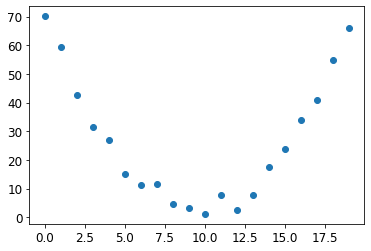

In [200]:
speed=torch.randn(20)*3+0.75*(time-9.5)**2+1
plt.scatter(time,speed)

We've added a bit of random noise, since measuring things manually isn't precise.

a function of the form $a*(time**2)+(b*time)+c$

In [201]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

 Thus, to find the best quadratic function, we only need to find the best values for a, b, and c.

- We need to define first what we mean by "best." 
- We define this precisely by choosing a loss function, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions.
    - 여기서 'best'의 의미는 정확하게 손실 함수를 선택함으로써 정의하는데, 함수의 낮은 값이 더 나은 예측에 기반한 예측과 target을 반환하는 것이다.
- For continuous data, it's common to use mean squared error:

In [202]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

**Step 1: Initialize the parameters**

In [229]:
params=torch.randn(3).requires_grad_()

In [230]:
orig_params=params.clone()

In [231]:
orig_params

tensor([-0.6300,  0.2694,  0.7482], grad_fn=<CloneBackward0>)

**Step 2: Calculate the predictions**

In [232]:
preds=f(time,params)

In [233]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

In [234]:
to_np??

Signature: to_np(x)
Source:   
def to_np(x):
    "Convert a tensor to a numpy array."
    return apply(lambda o: o.data.cpu().numpy(), x)
File:      ~/anaconda3/envs/csy/lib/python3.8/site-packages/fastai/torch_core.py
Type:      function


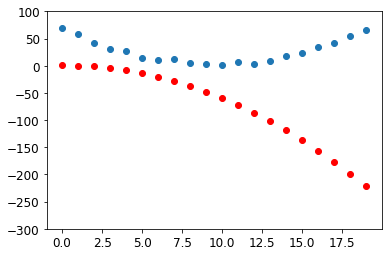

In [235]:
show_preds(preds)

our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

**Step 3: Calculate the loss**

In [236]:
loss=mse(preds,speed)
loss

tensor(127.6359, grad_fn=<SqrtBackward0>)

**Step 4: Calculate the gradients**

In [237]:
loss.backward()

In [238]:
params.grad

tensor([-164.3499,  -10.5352,   -0.7926])

In [239]:
params.grad * 1e-5

tensor([-1.6435e-03, -1.0535e-04, -7.9262e-06])

We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [240]:
params

tensor([-0.6300,  0.2694,  0.7482], requires_grad=True)

**Step 5: Step the weights**

In [241]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

> a: Understanding this bit depends on remembering recent history. To calculate the gradients we call backward on the loss. But this loss was itself calculated by mse, which in turn took preds as an input, which was calculated using f taking as an input params, which was the object on which we originally called required_grads_—which is the original call that now allows us to call backward on loss. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

> a: 이 비트를 이해하는 것은 최근 기록을 기억하느냐에 달려있다. gradient를 계산하는 것을 손실에서 backward로 부른다. 하지만 그 손실은 mse에 의해 스스로 계산되었고, 이를 입력으로 pred를 받아들였고, f를 입력 매개 변수로 사용해 계산되었는데 이게 손실에서 backward라 부른 것이자 원래 required_grads_라 부르는 것이었다. 이 함수의 연결성을 함수의 수학적 구성으로 부르고, 파이토치에서는 gradient를 계산하기 위해 미적분의 chain rule을 사용한다.

In [242]:
preds = f(time,params)
mse(preds,speed)

tensor(127.3647, grad_fn=<SqrtBackward0>)

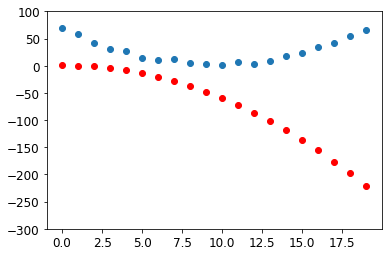

In [243]:
show_preds(preds)

we'll create a function to apply one step:

In [244]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

**Step 6: Repeat the process**

In [245]:
for i in range(10): apply_step(params)

127.36465454101562
127.09349060058594
126.82237243652344
126.55130004882812
126.2802963256836
126.00932312011719
125.73841094970703
125.46753692626953
125.19672393798828
124.92595672607422


In [246]:
params=orig_params.detach().requires_grad_()

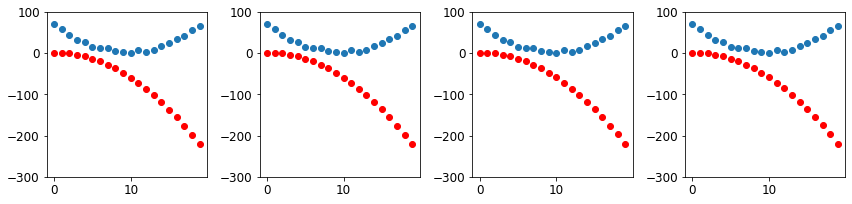

In [247]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

**Step 7: stop**

## Summarizing Gradient Descent

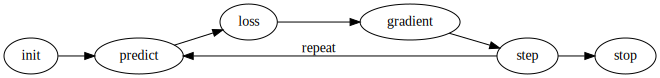

In [249]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [274]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We'll use 1 for 3s and 0 for 7s:

In [275]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [276]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [277]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel 

In [278]:
def init_params(size,std=1.0): return(torch.randn(size)*std).requires_grad_()

In [284]:
weights = init_params((28*28,1))

The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). 

You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

In [285]:
bias=init_params(1)

이미지 한 개 예측 계산해보기

In [286]:
(train_x[0]*weights.T).sum() + bias

tensor([-7.7136], grad_fn=<AddBackward0>)

In Python, matrix multiplication is represented with the @ operator. Let's try it:

In [287]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -7.7136],
        [-14.9169],
        [ -6.2609],
        ...,
        [ -4.8340],
        [ -0.3482],
        [  6.8171]], grad_fn=<AddBackward0>)

In [288]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [False]])

In [289]:
corrects.float().mean().item()

0.2702484726905823

In [294]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.25701838731765747

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, trgts, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

This would mean our loss function would receive these values as its inputs:

In [295]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [296]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

`torch.where(a,b,c)` is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))], except it works on tensors, at C/CUDA speed. 

In [297]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [298]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [299]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

## Sigmoid

One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

In [301]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

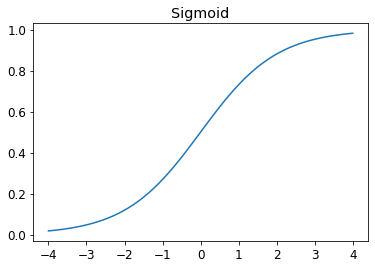

In [302]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, **it takes any input value, positive or negative**, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients.

In [303]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

## SGD and Mini-Batches

Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an optimization step.
- gradient에 따라 가중치를 변경하거나 업데이트하는 단계를 최적화 단계라고 한다.

*A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch.*

**Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this book.**

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. 

One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. **PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called DataLoader**.
- 미니 배치를 만들기 전에 epoc을 순서대로가 아닌 임의로 섞는 것이 일반적이다. 파이토치와 패스트에이아이는 임의로 섞고, 미니배치 수집할 DataLoader라고 불리는 클래스가 있다.

A DataLoader can take any Python collection and turn it into an iterator over many batches, like so:

In [304]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. 

Here's an example of an extremely simple Dataset:

In [305]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a Dataset to a DataLoader we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:
- Dataset을 DataLoader에 전달하면 독립변수, 종속변수의 배치를 나타내는 텐서의 튜플인 많은 배치를 다시 얻을 것이다.

In [306]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting It All Together

In [307]:
weights = init_params((28*28,1))
bias = init_params(1)

In [308]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [310]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [311]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [312]:
preds = linear1(batch)
preds

tensor([[14.9930],
        [10.0441],
        [ 4.8257],
        [ 9.4000]], grad_fn=<AddBackward0>)

In [313]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0020, grad_fn=<MeanBackward0>)

In [314]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0003), tensor([-0.0020]))

In [315]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [316]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0006), tensor([-0.0040]))

In [317]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0009), tensor([-0.0060]))

The gradients have changed! *The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored*. So, we have to set the current gradients to 0 first:

In [318]:
weights.grad.zero_()
bias.grad.zero_();

In [319]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [320]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [321]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [323]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [324]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [325]:
validate_epoch(linear1)

0.6301

In [326]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6938

In [327]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8857 0.9321 0.9433 0.9482 0.9516 0.9545 0.9565 0.9584 0.9614 0.9623 0.9628 0.9643 0.9658 0.9658 0.9662 0.9662 0.9662 0.9672 0.9672 0.9672 

We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an optimizer.
- 파이토치에서 최적화 도구라 불리는 SGD 단계를 처리할 객체를 만들 것이다.

## Creating an Optimizer

The first thing we can do is replace our linear1 function with PyTorch's `nn.Linear` module. 

A module is an object of a class that inherits from the PyTorch `nn.Module` class. 

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

In [329]:
linear_model = nn.Linear(28*28,1)

In [330]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [331]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

In [333]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [334]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [335]:
validate_epoch(linear_model)

0.2646

Let's put our little training loop in a function, to make things simpler:

In [336]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [337]:
train_model(linear_model, 20)

0.4932 0.4932 0.6763 0.8701 0.9209 0.9365 0.9516 0.957 0.9634 0.9658 0.9678 0.9702 0.9721 0.9741 0.9746 0.9761 0.977 0.9775 0.978 0.978 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [338]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7949 0.8535 0.916 0.9355 0.9472 0.9575 0.9634 0.9663 0.9678 0.9697 0.9712 0.9746 0.9751 0.9761 0.9765 0.9775 0.978 0.978 0.979 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoaders`:

In [339]:
dls = DataLoaders(dl, valid_dl)

To create a Learner without using an application (such as cnn_learner) we need to pass in all the elements that we've created in this chapter: the DataLoaders, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:
- cnn_learner같은 어플리케이션 없이 학습시키기 위해 선택적으로 인쇄할 모든 매트릭스, 손실 함수, 최적화 함수, 모델, DataLoaders를 모두 전달해야 한다.

In [340]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [341]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636537,0.503338,0.495584,00:00
1,0.467653,0.233290,0.786555,00:00
2,0.174121,0.161429,0.853778,00:00
3,0.077529,0.101020,0.915604,00:00
4,0.041900,0.075255,0.935721,00:00
5,0.027915,0.060847,0.948970,00:00
6,0.022117,0.051727,0.956820,00:00
7,0.019508,0.045614,0.963199,00:00
8,0.018168,0.041303,0.966634,00:00
9,0.017355,0.038121,0.968106,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! 

## Adding a Nonlinearity

the entire definition of a basic neural network:

In [343]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and b1 and b2 are bias tensors

In [345]:
w1 = init_params((28*28,30)) #  has 30 output activations
b1 = init_params(30)
w2 = init_params((30,1)) # must have 30 input activations, so they match
b2 = init_params(1)

That little function res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU. We think we can all agree that rectified linear unit sounds pretty fancy and complicated... But actually, there's nothing more to it than res.max(tensor(0.0))—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as F.relu:
- ReLU로 알려진 res.mas(0.0)은 정류된 선형 단위. 모든 음수를 0으로 바꿔준다.

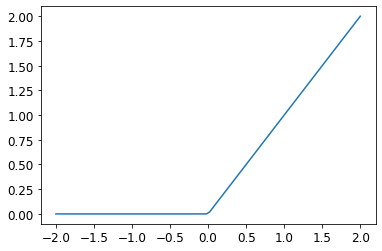

In [346]:
plot_function(F.relu)

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.
- 기본적인 아이디어는 선형함수를 더 사용할수록 모델이 더 많은 계산을 할 수 있어 더 복잡한 함수를 모데링할 수 있다는 것이다.
- 하지만 한 선형 층을 다른 층에 바로 붙이면 의미가 없는데, 왜냐하면 곱하고 여러번 더하는 건 곱하고 한 번에 더하는 것과 같기 때문이다. 즉 한 행에 에 있는 일련의 선형 층은 서로 다른 파라미터 집합을 가진 단일 선형 층으로 대체할 수 있다는 것이다.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The max function is particularly interesting, because it operates as a simple if statement.
- 만일 'max'와 같은 비선형 함수를 선형 함수 사이에 넣는다면 각 선형 층은 다른 층과 어느정도 분리되는 것으로 보고 유용한 작업을 할 수 있을 것으로 본다. 'max' 함수는 특히 if 구문을 사용하기 때문에 흥미롭다.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for w1 and w2 and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the `universal approximation theorem`. The three lines of code that we have here are known as layers. The first and third are known as linear layers, and the second line of code is known variously as a nonlinearity, or activation function.
- 'max'라는 함수는 임의의 높은 정확도로 계산 가능한 문제를 풀 수 있다는 것을 수학적으로 증명할 수 있다.
- 'w1','w2'의 right parameter를 찾을 수 있고, 이 행렬이 충분히 크다면 말이다.
- 임의의 wiggly 함수에 대해 선들을 합쳐서 근사할 수 있다.
- wiggly 함수에 가깝게 하기 위해서 보편 근사 정리라고 알려진 더 짧은 선들을 사용해야 한다.
- 이 세 줄의 선은 layer라 부르고, 첫번째, 세번째 줄은 선형 layer이며, 두 번째 줄은 비선형 layer이며, 활성화 함수이다.

In [347]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.
- nn.Sequential는 나열된 layer나 함수를 차례로 호출하는 모듈을 만든다.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the F.relu function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing F with nn and changing the capitalization. When using nn.Sequential, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see nn.ReLU() in this example.
- nn.Sequential을 사용할 경우, 파이토치는 모듈 버전을 사용할 것을 요구한다. 
- 이 모듈은 class이고, nn.ReLU에서 본 이유이기도 했던, instance화를 해야한다.

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.
- nn.Sequential은 모듈이기 때문에 파라미터를 가져올 수 있고, 포함한 모든 모듈의 매게변수 목록을 반환할 것이다.

In [348]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [349]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.275952,0.411253,0.506379,00:00
1,0.133328,0.214047,0.820903,00:00
2,0.075737,0.109673,0.919038,00:00
3,0.050957,0.074739,0.942100,00:00
4,0.039277,0.058585,0.961236,00:00
5,0.033197,0.049507,0.965162,00:00
6,0.029636,0.043790,0.966634,00:00
7,0.027287,0.039878,0.968106,00:00
8,0.025576,0.037031,0.970069,00:00
9,0.024243,0.034862,0.972031,00:00


the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

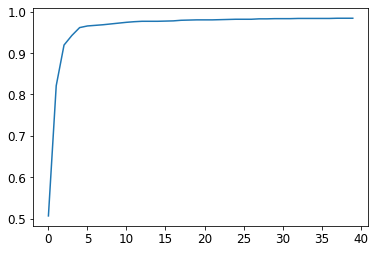

In [350]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [351]:
learn.recorder.values[-1][2]

0.9838076829910278

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
    - 정확한 파라미터 집합이 주어진다면 어떤 수준의 정확도(신경망)으로든 문제를 해결할 수 있다.
2. A way to find the best set of parameters for any function (stochastic gradient descent)
    - 모든 함수에 대해 최적의 매개함수 집합을 찾는 방법을 알 수 있다.

## Going Deeper

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.
- 두 개의 선형 layer를 가진 단일 비선형성이 충분히 어느 함수든 잘 설명한다는 것을 알았다.
- 왜 깊은 모델을 사용해야할까? 그 이유는 성능이다. 
- deeper model에서는 많은 파라미터를 사용할 필요가 없다.
- layer가 더 많은 작은 행렬을 사용할 수 있다면 더 큰 행렬과 더 작은 layer를 가진 것보다 더 좋은 결과를 얻을 수 있다.

That means that we can train the model more quickly, and it will take up less memory.
- 모델을 더 빨리 학습시킬 수 있다면 더 적은 메모리를 사용할 것이다. 

what happens when we train an 18-layer model

In [356]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.109431,0.013922,0.994603,00:08


Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces.